# OpenAlex 학술지 단위 API로 수집

In [35]:
import pandas as pd
import requests
from tqdm.auto import tqdm
tqdm.pandas()
import json
import glob
import time
import re
from natsort import natsorted
import itertools
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

In [2]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.0.0 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "DNT": "1", # Do Not Track 요청 헤더 (사용자 추적 거부)
    # 필요한 추가 헤더를 여기에 추가
}

In [3]:
def request_until_success(url, headers, timeout=25, delay=5):
    """
    Continuously makes a request to the specified URL with a timeout until the request is successful.

    Args:
    - url (str): The URL to request.
    - timeout (int): The timeout for the request in seconds.
    - delay (int): The delay between retries in seconds.

    Returns:
    - response: The successful response from the server.
    """
    attempt = 1
    while True:
        try:
            # print(f"Attempt {attempt}")
            response = requests.get(url,headers=headers, timeout=timeout)
            response.raise_for_status()  # Raises HTTPError for bad responses
            # print("Request successful")
            return response.json()
        except requests.Timeout as e:
            print(f"Request timed out: {e}")
        except requests.RequestException as e:
            print(f"Request failed: {e}")
        
        # print(f"Retrying in {delay} seconds...")
        time.sleep(delay)
        attempt += 1

### 한국학 저널 논문 서지정보 수집 (2024년 3월 스냅샷 기준)
https://github.com/ourresearch/openalex-guts/blob/main/files-for-datadumps/standard-format/RELEASE_NOTES.txt

In [7]:
# url with a placeholder for cursor
example_url_with_cursor = 'https://api.openalex.org/works?filter=primary_location.source.id:S945374760&per-page=200&cursor={}&mailto=kuntakim88@gmail.com'
cursor = '*'

In [8]:
 # set cursor value and request page from OpenAlex
url = example_url_with_cursor.format(cursor)
print('\n' + url)
page_with_results = requests.get(url).json()
page_with_results


https://api.openalex.org/works?filter=primary_location.source.id:S945374760&per-page=200&cursor=*&mailto=kuntakim88@gmail.com


{'meta': {'count': 577,
  'db_response_time_ms': 105,
  'page': None,
  'per_page': 200,
  'next_cursor': 'Ils3Ni4wLCAxLCAnaHR0cHM6Ly9vcGVuYWxleC5vcmcvVzI3ODAzODU5MDUnXSI=',
  'groups_count': None},
 'results': [{'id': 'https://openalex.org/W2134689261',
   'doi': 'https://doi.org/10.1353/jks.2011.0001',
   'title': 'The Domestication of South Korean Pre-College Study Abroad in the First Decade of the Millennium',
   'display_name': 'The Domestication of South Korean Pre-College Study Abroad in the First Decade of the Millennium',
   'publication_year': 2011,
   'publication_date': '2011-03-11',
   'ids': {'openalex': 'https://openalex.org/W2134689261',
    'doi': 'https://doi.org/10.1353/jks.2011.0001',
    'mag': '2134689261'},
   'language': 'en',
   'primary_location': {'is_oa': False,
    'landing_page_url': 'https://doi.org/10.1353/jks.2011.0001',
    'pdf_url': None,
    'source': {'id': 'https://openalex.org/S945374760',
     'display_name': '\x98The \x9cjournal of Korean studi

In [7]:
# end = int(page_with_results['meta']['count']/200)+1
# start = 0
# print(start, end)

0 3


In [9]:
journals = ['S120959427', 'S175852239','S171037360','S2765074192','S945374760','S4210213186','S4210173974']

In [10]:
for jour in journals:
    print(jour)
    # url with a placeholder for cursor
    num = 1
    cursor = '*'
    base_url = f'https://api.openalex.org/works?filter=primary_location.source.id:{jour}&per-page={num}&cursor={cursor}&mailto=kuntakim88@gmail.com'
    page_with_results = requests.get(base_url).json()
    end = int(page_with_results['meta']['count']/200)+1
    start = 0
    for idx in tqdm(range(start,end)):
        # set cursor value and request page from OpenAlex
        num = 200
        url = f'https://api.openalex.org/works?filter=primary_location.source.id:{jour}&per-page={num}&cursor={cursor}&mailto=kuntakim88@gmail.com'
        # url = base_url.format(cursor)
        # page_with_results = requests.get(url).json()
        page_with_results = request_until_success(url,headers)
        
        # json으로 저장
        with open(f'./data/{jour}_{idx}.json','w') as f:
            json.dump(page_with_results,f)
        # next page
        cursor = page_with_results['meta']['next_cursor']

S120959427


  0%|          | 0/3 [00:00<?, ?it/s]

S175852239


  0%|          | 0/3 [00:00<?, ?it/s]

S171037360


  0%|          | 0/2 [00:00<?, ?it/s]

S2765074192


  0%|          | 0/4 [00:00<?, ?it/s]

S945374760


  0%|          | 0/3 [00:00<?, ?it/s]

S4210213186


  0%|          | 0/5 [00:00<?, ?it/s]

S4210173974


  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# json 파일 리스트
file_list = natsorted(glob.glob('./data/*.json'))
print(len(file_list))
file_list

21


['./data\\S120959427_0.json',
 './data\\S120959427_1.json',
 './data\\S120959427_2.json',
 './data\\S171037360_0.json',
 './data\\S171037360_1.json',
 './data\\S175852239_0.json',
 './data\\S175852239_1.json',
 './data\\S175852239_2.json',
 './data\\S945374760_0.json',
 './data\\S945374760_1.json',
 './data\\S945374760_2.json',
 './data\\S2765074192_0.json',
 './data\\S2765074192_1.json',
 './data\\S2765074192_2.json',
 './data\\S2765074192_3.json',
 './data\\S4210173974_0.json',
 './data\\S4210213186_0.json',
 './data\\S4210213186_1.json',
 './data\\S4210213186_2.json',
 './data\\S4210213186_3.json',
 './data\\S4210213186_4.json']

In [12]:
# 여러 json 파일을 읽어서 result만 하나의 리스트로 저장하기
openalex_json = []
for file in tqdm(file_list):
    with open(file,'r') as f:
        temp_json = json.load(f)['results']
    openalex_json.extend(temp_json)

  0%|          | 0/21 [00:00<?, ?it/s]

In [30]:
# pandas dataframe으로 변환
df = pd.DataFrame.from_dict(openalex_json)
df

id  \
0     https://openalex.org/W4384432764   
1     https://openalex.org/W4384432829   
2     https://openalex.org/W1578642520   
3     https://openalex.org/W1590043962   
4      https://openalex.org/W210363985   
...                                ...   
3375  https://openalex.org/W2115655314   
3376  https://openalex.org/W2154921451   
3377  https://openalex.org/W2162052910   
3378  https://openalex.org/W4243393701   
3379  https://openalex.org/W4251211576   

                                           doi  \
0     https://doi.org/10.1353/seo.2023.a902140   
1     https://doi.org/10.1353/seo.2023.a902142   
2        https://doi.org/10.1353/seo.2015.0003   
3        https://doi.org/10.1353/seo.2013.0023   
4        https://doi.org/10.1353/seo.2014.0005   
...                                        ...   
3375      https://doi.org/10.1353/ks.1992.0016   
3376      https://doi.org/10.1353/ks.1992.0014   
3377      https://doi.org/10.1353/ks.1992.0007   
3378      https://doi.org/10.1353/ks.1993.0020   
3379      https://doi.org/10.1353/ks.1993.0009   

                                                  title  \
0     Felled Forests and Fallowed Fields: Establishi...   
1     The History of the Formation of Silhak in Mode...   
2     Diplomatic War: Inter-Korean Relations in the ...   
3     More Valuable than Gold: Korean Tungsten and t...   
4     Parhae in Historiography and Archaeology: Inte...   
...                                                 ...   
3375            <i>The Bronze Age in Korea</i> (review)   
3376  &lt;i&gt;Korea Old and New: A History&lt;/i&gt...   
3377  &lt;i&gt;Alliance Under Tension: The Evolution...   
3378                                       Contributors   
3379                                     Editor's Note:   

                                           display_name  publication_year  \
0     Felled Forests and Fallowed Fields: Establishi...              2023   
1     The History of the Formation of Silhak in Mode...              2023   
2     Diplomatic War: Inter-Korean Relations in the ...              2015   
3     More Valuable than Gold: Korean Tungsten and t...              2013   
4     Parhae in Historiography and Archaeology: Inte...              2014   
...                                                 ...               ...   
3375            <i>The Bronze Age in Korea</i> (review)              1992   
3376  &lt;i&gt;Korea Old and New: A History&lt;/i&gt...              1992   
3377  &lt;i&gt;Alliance Under Tension: The Evolution...              1992   
3378                                       Contributors              1993   
3379                                     Editor's Note:              1993   

     publication_date                                                ids  \
0          2023-06-01  {'openalex': 'https://openalex.org/W4384432764...   
1          2023-06-01  {'openalex': 'https://openalex.org/W4384432829...   
2          2015-01-01  {'openalex': 'https://openalex.org/W1578642520...   
3          2013-01-01  {'openalex': 'https://openalex.org/W1590043962...   
4          2014-01-01  {'openalex': 'https://openalex.org/W210363985'...   
...               ...                                                ...   
3375       1992-01-01  {'openalex': 'https://openalex.org/W2115655314...   
3376       1992-01-01  {'openalex': 'https://openalex.org/W2154921451...   
3377       1992-01-01  {'openalex': 'https://openalex.org/W2162052910...   
3378       1993-01-01  {'openalex': 'https://openalex.org/W4243393701...   
3379       1993-01-01  {'openalex': 'https://openalex.org/W4251211576...   

     language                                   primary_location     type  \
0          en  {'is_oa': False, 'landing_page_url': 'https://...  article   
1          en  {'is_oa': False, 'landing_page_url': 'https://...  article   
2          en  {'is_oa': False, 'landing_page_url': 'https://...  article   
3          en  {'is_oa': False, 'landing_page_url': 'https://...  article  

In [31]:
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)

In [32]:
df['journal'] = df['primary_location'].map(lambda x:x['source']['display_name'])
df['journal']

0       Seoul Journal of Korean Studies
1       Seoul Journal of Korean Studies
2       Seoul Journal of Korean Studies
3       Seoul Journal of Korean Studies
4       Seoul Journal of Korean Studies
                     ...               
3374                     Korean Studies
3375                     Korean Studies
3376                     Korean Studies
3377                     Korean Studies
3378                     Korean Studies
Name: journal, Length: 3379, dtype: object

In [33]:
df[pd.isna(df['journal'])]

Empty DataFrame
Columns: [id, doi, title, display_name, publication_year, publication_date, ids, language, primary_location, type, type_crossref, indexed_in, open_access, authorships, countries_distinct_count, institutions_distinct_count, corresponding_author_ids, corresponding_institution_ids, apc_list, apc_paid, has_fulltext, cited_by_count, cited_by_percentile_year, biblio, is_retracted, is_paratext, primary_topic, topics, keywords, concepts, mesh, locations_count, locations, best_oa_location, sustainable_development_goals, grants, referenced_works_count, referenced_works, related_works, ngrams_url, abstract_inverted_index, cited_by_api_url, counts_by_year, updated_date, created_date, fulltext_origin, versions, journal]
Index: []

[0 rows x 48 columns]

In [34]:
# Normalize the journal names
normalized_journal = df['journal'].str.lower()  # Lowercase for uniformity
normalized_journal = normalized_journal.str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)  # Remove punctuation
normalized_journal = normalized_journal.str.replace(r"\s+", " ", regex=True)  # Replace multiple spaces with single
normalized_journal = normalized_journal.str.strip()  # Strip whitespace

In [35]:
# Update the mapping with the specified unifications
updated_mapping = {
    "korean studies": "Korean Studies",
    "the review of korean studies": "The Review of Korean Studies",
    "the journal of korean studies": "The Journal of Korean Studies",
    "korea journal": "Korea Journal",
    "seoul journal of korean studies": "Seoul Journal of Korean Studies",
    "acta koreana": "Acta Koreana",
    "european journal of korean studies": "European Journal of Korean Studies",
    "review of korean studies": "The Review of Korean Studies",
    "the journal of korean studies seattle wash 1979": "The Journal of Korean Studies",  # Update for unification
    "acta koreana cdrom": "Acta Koreana"  # Update for unification
}

In [36]:
df['journal'] = normalized_journal.map(updated_mapping)

In [37]:
df['journal'].value_counts()

journal
Korean Studies                        802
The Review of Korean Studies          644
The Journal of Korean Studies         577
Korea Journal                         516
Seoul Journal of Korean Studies       446
Acta Koreana                          292
European Journal of Korean Studies    102
Name: count, dtype: int64

<Axes: xlabel='publication_year'>

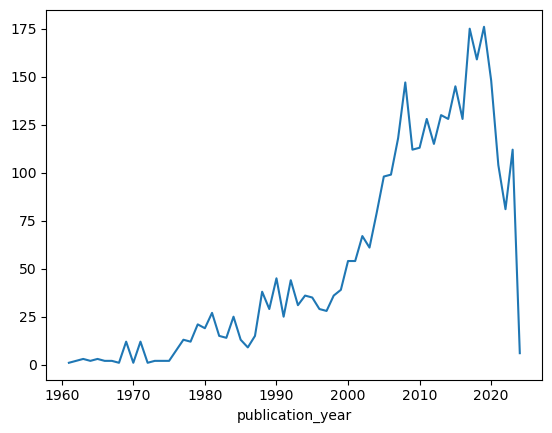

In [38]:
df['publication_year'].value_counts().sort_index().plot()

In [39]:
# 2000년부터 하기
df.groupby('journal')['publication_year'].min()

journal
Acta Koreana                          2000
European Journal of Korean Studies    2015
Korea Journal                         1961
Korean Studies                        1977
Seoul Journal of Korean Studies       1988
The Journal of Korean Studies         1969
The Review of Korean Studies          1997
Name: publication_year, dtype: int64

In [41]:
# Korea Journal과 The Review of Korean Studies 보완 필요
df.groupby('journal')['publication_year'].max()

journal
Acta Koreana                          2023
European Journal of Korean Studies    2023
Korea Journal                         2021
Korean Studies                        2023
Seoul Journal of Korean Studies       2023
The Journal of Korean Studies         2024
The Review of Korean Studies          2020
Name: publication_year, dtype: int64

In [13]:
# df = df[(df['publication_year']>=2000) & (df['publication_year']<=2020)].reset_index(drop=True)

In [43]:
df.loc[df['journal'].isin(['The Review of Korean Studies','Korea Journal','Seoul Journal of Korean Studies','Acta Koreana']),'origin'] = 'in'
df.loc[~df['journal'].isin(['The Review of Korean Studies','Korea Journal','Seoul Journal of Korean Studies','Acta Koreana']),'origin'] = 'out'

In [45]:
df['origin'].value_counts()

origin
in     1898
out    1481
Name: count, dtype: int64

In [27]:
def index_to_text(abstract_inverted_index):
    abstract_index = {}
    for k, vlist in abstract_inverted_index.items():
        for v in vlist:
            abstract_index[v] = k
    abstract = ' '.join(abstract_index[k] for k in sorted(abstract_index.keys()))
    return abstract

In [47]:
# index to text
df['abstract'] = df[~pd.isna(df['abstract_inverted_index'])]['abstract_inverted_index'].progress_map(lambda x:index_to_text(x))
df['abstract']

  0%|          | 0/1965 [00:00<?, ?it/s]

0       Abstract: Goryeo (918–1392) was a politically ...
1       Abstract: This article examines the historical...
2       The period of the 1970s was a turning point in...
3       A central component of the Japanese government...
4       The history of the kingdom of Parhae (Ch. Boha...
                              ...                        
3374    128BOOK REVIEWS rather than philosophy. And if...
3375    Book Reviews Korea Old and New: A History, by ...
3376    BOOK REVIEWS123 These volumes are more than ju...
3377                                                  NaN
3378                                                  NaN
Name: abstract, Length: 3379, dtype: object

In [48]:
df.columns

Index(['id', 'doi', 'title', 'display_name', 'publication_year',
       'publication_date', 'ids', 'language', 'primary_location', 'type',
       'type_crossref', 'indexed_in', 'open_access', 'authorships',
       'countries_distinct_count', 'institutions_distinct_count',
       'corresponding_author_ids', 'corresponding_institution_ids', 'apc_list',
       'apc_paid', 'has_fulltext', 'cited_by_count',
       'cited_by_percentile_year', 'biblio', 'is_retracted', 'is_paratext',
       'primary_topic', 'topics', 'keywords', 'concepts', 'mesh',
       'locations_count', 'locations', 'best_oa_location',
       'sustainable_development_goals', 'grants', 'referenced_works_count',
       'referenced_works', 'related_works', 'ngrams_url',
       'abstract_inverted_index', 'cited_by_api_url', 'counts_by_year',
       'updated_date', 'created_date', 'fulltext_origin', 'versions',
       'journal', 'origin', 'abstract'],
      dtype='object')

In [49]:
df.loc[pd.isna(df['doi']),'journal'].value_counts()

journal
The Review of Korean Studies       333
Seoul Journal of Korean Studies    216
Korea Journal                      112
The Journal of Korean Studies       40
Acta Koreana                        29
Korean Studies                      27
Name: count, dtype: int64

In [50]:
# df.to_pickle('./240312_KS_works.pkl')
df.to_pickle('./240402_KS_works.pkl')

### 저자
저자의 소속, 국적(추가 처리 필요) 등

In [51]:
df['authorships'][0]

[{'author_position': 'first',
  'author': {'id': 'https://openalex.org/A5023897005',
   'display_name': 'Aaron Molnar',
   'orcid': 'https://orcid.org/0009-0005-7904-1247'},
  'institutions': [],
  'countries': [],
  'is_corresponding': True,
  'raw_author_name': 'Aaron Molnar',
  'raw_affiliation_string': '',
  'raw_affiliation_strings': []}]

In [56]:
df['authorships_id'] = df['authorships'].progress_map(lambda x:[a['author']['id'] for a in x])

  0%|          | 0/3379 [00:00<?, ?it/s]

In [57]:
authorship_id = df['authorships'].progress_map(lambda x:[a['author']['id'] for a in x]).tolist()
authorship_id = list(set(list(itertools.chain(*authorship_id))))

  0%|          | 0/3379 [00:00<?, ?it/s]

In [58]:
for id in tqdm(authorship_id):
    id = id.split('/')[-1]
    url = f'https://api.openalex.org/authors/{id}&mailto=kuntakim88@gmail.com'
    page_with_results = request_until_success(url,headers)
    # json으로 저장
    with open(f'./data/author/{id}.json','w') as f:
            json.dump(page_with_results,f)

  0%|          | 0/2434 [00:00<?, ?it/s]

In [60]:
author_file_list = glob.glob('./data/author/*.json')
len(author_file_list)

2343

In [61]:
openalex_author_json = []
for file in tqdm(author_file_list):
    with open(file,'r') as f:
        temp_json = json.load(f)
    openalex_author_json.append(temp_json)

  0%|          | 0/2343 [00:00<?, ?it/s]

In [62]:
df_author = pd.DataFrame(openalex_author_json)

In [63]:
df_author['country_code'] = df_author.loc[df_author['last_known_institutions'].str.len()!=0,'last_known_institutions'].progress_map(lambda x:x[0]['country_code'])

  0%|          | 0/1254 [00:00<?, ?it/s]

In [64]:
df_author['country_code'].value_counts()

country_code
KR    518
US    379
GB     59
JP     44
CN     41
CA     33
AU     30
DE     16
RU     15
FR     13
NL     10
HK     10
NZ      7
ES      6
FI      6
SE      5
IN      5
AT      5
IL      4
DK      4
IT      3
CZ      3
CL      2
PH      2
SG      2
BE      2
HU      2
MN      2
MT      2
NO      2
RO      1
PE      1
KZ      1
TW      1
TN      1
BJ      1
MO      1
GR      1
TH      1
MX      1
LA      1
VN      1
AE      1
CY      1
PL      1
AZ      1
AR      1
UZ      1
IQ      1
BG      1
IE      1
SI      1
Name: count, dtype: int64

In [65]:
# 최신 저자 소속 국가 없는 경우
pd.isna(df_author['country_code']).sum()

1089

In [66]:
author_country = df_author[['id','country_code']].to_dict(orient='records')
author_country = [d for d in author_country if d['country_code'] == d['country_code']]

In [67]:
# authorships_id 열의 각 요소에 대해 country_code 매칭
def get_country_codes(author_ids):
    country_codes = []
    for author_id in author_ids:
        country_code = next((d['country_code'] for d in author_country if d['id'] == author_id), None)
        country_codes.append(country_code)
    return country_codes

In [68]:
df['country_code'] = df['authorships_id'].apply(get_country_codes)

In [69]:
df['country_code'] = df['country_code'].apply(lambda lst: [x for x in lst if x is not None])

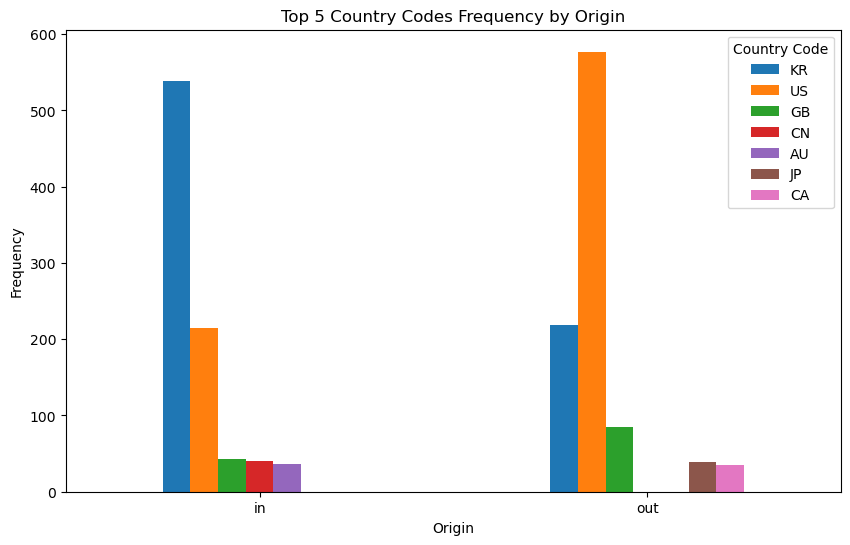

In [70]:
# country_code 리스트를 행으로 확장
df_exploded = df.explode('country_code')

# origin 및 country_code 별로 그룹화하여 출현 횟수 계산
count_per_origin_country = df_exploded.groupby(['origin', 'country_code']).size().reset_index(name='count')

# 빈 country_code 제거
df_exploded = df_exploded[df_exploded['country_code'].notna()]

# origin 별, country_code 별 출현 횟수 계산 및 상위 5개 선택
top_5_countries_by_origin = df_exploded.groupby('origin')['country_code'].value_counts().groupby(level=0).head(5).unstack(fill_value=0)

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 각 origin 유형별로 상위 5개 country_code의 빈도를 막대 그래프로 시각화
top_5_countries_by_origin.plot(kind='bar', ax=ax)

# 축 이름 및 타이틀 설정
ax.set_xlabel('Origin')
ax.set_ylabel('Frequency')
ax.set_title('Top 5 Country Codes Frequency by Origin')

# 범례 설정
ax.legend(title='Country Code')

# 그래프 표시
plt.xticks(rotation=0)  # x축 라벨 회전 설정
plt.show()

In [71]:
df['country_code'].value_counts()

country_code
[]              1315
[US]             705
[KR]             655
[GB]             106
[AU]              61
                ... 
[KR, CA]           1
[US, TW, KR]       1
[GB, NL]           1
[LA]               1
[DE, KR]           1
Name: count, Length: 105, dtype: int64

### 피인용
연구 대상 논문을 인용한 publications 수집 (다른 DB로 보완 필요함)

In [4]:
df = pd.read_pickle('./240402_KS_works.pkl')
df

id  \
0     https://openalex.org/W4384432764   
1     https://openalex.org/W4384432829   
2     https://openalex.org/W1578642520   
3     https://openalex.org/W1590043962   
4      https://openalex.org/W210363985   
...                                ...   
3374  https://openalex.org/W2115655314   
3375  https://openalex.org/W2154921451   
3376  https://openalex.org/W2162052910   
3377  https://openalex.org/W4243393701   
3378  https://openalex.org/W4251211576   

                                           doi  \
0     https://doi.org/10.1353/seo.2023.a902140   
1     https://doi.org/10.1353/seo.2023.a902142   
2        https://doi.org/10.1353/seo.2015.0003   
3        https://doi.org/10.1353/seo.2013.0023   
4        https://doi.org/10.1353/seo.2014.0005   
...                                        ...   
3374      https://doi.org/10.1353/ks.1992.0016   
3375      https://doi.org/10.1353/ks.1992.0014   
3376      https://doi.org/10.1353/ks.1992.0007   
3377      https://doi.org/10.1353/ks.1993.0020   
3378      https://doi.org/10.1353/ks.1993.0009   

                                                  title  \
0     Felled Forests and Fallowed Fields: Establishi...   
1     The History of the Formation of Silhak in Mode...   
2     Diplomatic War: Inter-Korean Relations in the ...   
3     More Valuable than Gold: Korean Tungsten and t...   
4     Parhae in Historiography and Archaeology: Inte...   
...                                                 ...   
3374            <i>The Bronze Age in Korea</i> (review)   
3375  &lt;i&gt;Korea Old and New: A History&lt;/i&gt...   
3376  &lt;i&gt;Alliance Under Tension: The Evolution...   
3377                                       Contributors   
3378                                     Editor's Note:   

                                           display_name  publication_year  \
0     Felled Forests and Fallowed Fields: Establishi...              2023   
1     The History of the Formation of Silhak in Mode...              2023   
2     Diplomatic War: Inter-Korean Relations in the ...              2015   
3     More Valuable than Gold: Korean Tungsten and t...              2013   
4     Parhae in Historiography and Archaeology: Inte...              2014   
...                                                 ...               ...   
3374            <i>The Bronze Age in Korea</i> (review)              1992   
3375  &lt;i&gt;Korea Old and New: A History&lt;/i&gt...              1992   
3376  &lt;i&gt;Alliance Under Tension: The Evolution...              1992   
3377                                       Contributors              1993   
3378                                     Editor's Note:              1993   

     publication_date                                                ids  \
0          2023-06-01  {'openalex': 'https://openalex.org/W4384432764...   
1          2023-06-01  {'openalex': 'https://openalex.org/W4384432829...   
2          2015-01-01  {'openalex': 'https://openalex.org/W1578642520...   
3          2013-01-01  {'openalex': 'https://openalex.org/W1590043962...   
4          2014-01-01  {'openalex': 'https://openalex.org/W210363985'...   
...               ...                                                ...   
3374       1992-01-01  {'openalex': 'https://openalex.org/W2115655314...   
3375       1992-01-01  {'openalex': 'https://openalex.org/W2154921451...   
3376       1992-01-01  {'openalex': 'https://openalex.org/W2162052910...   
3377       1993-01-01  {'openalex': 'https://openalex.org/W4243393701...   
3378       1993-01-01  {'openalex': 'https://openalex.org/W4251211576...   

     language                                   primary_location     type  \
0          en  {'is_oa': False, 'landing_page_url': 'https://...  article   
1          en  {'is_oa': False, 'landing_page_url': 'https://...  article   
2          en  {'is_oa': False, 'landing_page_url': 'https://...  article   
3          en  {'is_oa': False, 'landing_page_url': 'https://...  article  

In [57]:
df['cited_by_count'].sum()

6230

In [58]:
df['cited_by_count'].describe()

count    3379.000000
mean        1.843741
std         5.950394
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        93.000000
Name: cited_by_count, dtype: float64

<Axes: >

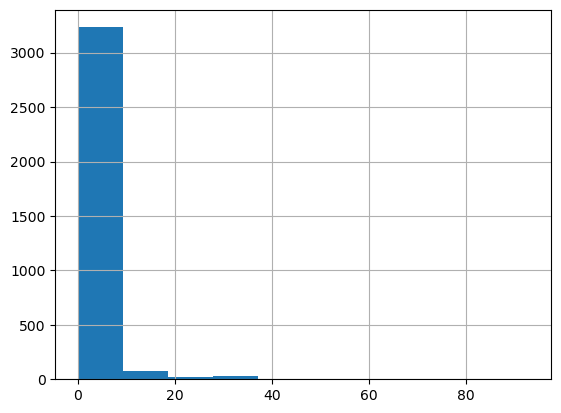

In [76]:
df['cited_by_count'].hist()

In [7]:
cited_list = df['id'].tolist()
cited_list = [id.split('/')[-1] for id in cited_list]
len(cited_list)

3379

In [8]:
def get_cites(id):
     # url with a placeholder for cursor
     cursor = '*'
     url = f'https://api.openalex.org/works?filter=cites:{id}&per-page=200&cursor={cursor}&mailto=kuntakim88@gmail.com'
     page_with_results = requests.get(url).json()
     end = int(page_with_results['meta']['count']/200)+1
     start = 0
     openalex_json = []
     for idx in range(start,end):
          # set cursor value and request page from OpenAlex
          url = f'https://api.openalex.org/works?filter=cites:{id}&per-page=200&cursor={cursor}&mailto=kuntakim88@gmail.com'
          # page_with_results = requests.get(url).json()
          page_with_results = request_until_success(url,headers,timeout=15, delay=5)
          # time.sleep(0.5)
          # print(page_with_results)
          # json으로 저장
          # with open(f'../data/pb_{idx}.json','w') as f:
          #      json.dump(page_with_results,f)
          openalex_json.extend(page_with_results['results'])
          # next page
          cursor = page_with_results['meta']['next_cursor']
     return openalex_json

In [10]:
for id in tqdm(cited_list):
    result = get_cites(id)
    # json으로 저장
    with open(f'./data/cited/{id}.json','w') as f:
        json.dump(result,f)

  0%|          | 0/3379 [00:00<?, ?it/s]

In [64]:
cited_file_list = glob.glob('./data/cited/*.json')
len(cited_file_list)

3379

In [73]:
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        temp_json = json.load(file)
    # 리스트가 비어 있지 않은지 확인
    if temp_json:
        for d in temp_json:
            d['cites'] = Path(file_path).stem
        # print("Updated list:", temp_json)
    return temp_json
    
# 결과를 저장할 리스트 초기화
openalex_cited_json = []

with ThreadPoolExecutor(max_workers=12) as executor:
    # tqdm으로 진행 상황 표시
    for result in tqdm(executor.map(load_json, cited_file_list), total=len(cited_file_list)):
        openalex_cited_json.extend(result)

  0%|          | 0/3379 [00:00<?, ?it/s]

In [ ]:
# openalex_cited_json = []
# for file in tqdm(cited_file_list):
#     with open(file,'r') as f:
#         temp_json = json.load(f)
#     openalex_cited_json.extend(temp_json)

In [74]:
# df_cited = pd.DataFrame(openalex_cited_json).drop_duplicates(subset='id').reset_index(drop=True)
df_cited = pd.DataFrame(openalex_cited_json)
df_cited

id  \
0     https://openalex.org/W3014747407   
1     https://openalex.org/W1935281467   
2      https://openalex.org/W253152192   
3      https://openalex.org/W815816339   
4     https://openalex.org/W2071789989   
...                                ...   
6215  https://openalex.org/W2026740962   
6216  https://openalex.org/W2481060642   
6217  https://openalex.org/W3137638170   
6218  https://openalex.org/W2332318559   
6219  https://openalex.org/W2728471449   

                                                    doi  \
0            https://doi.org/10.33526/ejks.20201902.171   
1                 https://doi.org/10.1353/seo.2015.0012   
2                                                  None   
3                                                  None   
4                 https://doi.org/10.1353/jks.2013.0002   
...                                                 ...   
6215          https://doi.org/10.1142/s0192415x98000270   
6216                                               None   
6217                                               None   
6218  https://doi.org/10.17813/maiq.11.4.85182005l51...   
6219       https://doi.org/10.1007/978-3-319-59788-1_11   

                                                  title  \
0     Modern Womanhood, the Ideology of the Housewif...   
1     Progeny of the Koryŏ Dynasty: The Kaesŏng Wang...   
2     Mortuary Ritual and Social Development in Iron...   
3           A study of the Boseong River Valley culture   
4     Racialization and Colonial Space: Intermarriag...   
...                                                 ...   
6215  Effects of <i>ChunDoSunBup</i> Qi-training on ...   
6216  Translation and post-bellum image building: ko...   
6217  Wit(h)nessing trauma in Han Kang’s the white b...   
6218  The Broken Promises of Democracy: Protest-Repr...   
6219  English Education in North Korea in the 1990s–...   

                                           display_name  publication_year  \
0     Modern Womanhood, the Ideology of the Housewif...              2020   
1     Progeny of the Koryŏ Dynasty: The Kaesŏng Wang...              2015   
2     Mortuary Ritual and Social Development in Iron...              2014   
3           A study of the Boseong River Valley culture              2002   
4     Racialization and Colonial Space: Intermarriag...              2013   
...                                                 ...               ...   
6215  Effects of <i>ChunDoSunBup</i> Qi-training on ...              1998   
6216  Translation and post-bellum image building: ko...              2013   
6217  Wit(h)nessing trauma in Han Kang’s the white b...              2020   
6218  The Broken Promises of Democracy: Protest-Repr...              2006   
6219  English Education in North Korea in the 1990s–...              2017   

     publication_date                                                ids  \
0          2020-04-01  {'openalex': 'https://openalex.org/W3014747407...   
1          2015-01-01  {'openalex': 'https://openalex.org/W1935281467...   
2          2014-01-01  {'openalex': 'https://openalex.org/W253152192'...   
3          2002-12-01  {'openalex': 'https://openalex.org/W815816339'...   
4          2013-03-13  {'openalex': 'https://openalex.org/W2071789989...   
...               ...                                                ...   
6215       1998-01-01  {'openalex': 'https://openalex.org/W2026740962...   
6216       2013-07-02  {'openalex': 'https://openalex.org/W2481060642...   
6217       2020-01-01  {'openalex': 'https://openalex.org/W3137638170...   
6218       2006-12-01  {'openalex': 'https://openalex.org/W2332318559...   
6219       2017-01-01  {'openalex': 'https://openalex.org/W2728471449...   

     language                                   primary_location  \
0          en  {'is_oa': False, 'landing_page_url': 'https://...   
1          en  {'is_oa': False, 'landing_page_url': 'https://...   
2          en  {'is_oa': False, 'landing_page_url': 'https://...   
3  

In [67]:
# df_cited[df_cited.duplicated(subset='id',keep=False)].sort_values('id')

In [75]:
# index to text
df_cited['abstract'] = df_cited[~pd.isna(df_cited['abstract_inverted_index'])]['abstract_inverted_index'].progress_map(lambda x:index_to_text(x))
df_cited['abstract']

  0%|          | 0/4629 [00:00<?, ?it/s]

0       This paper attempts to clarify how young femal...
1       As the descendants of the Koryŏ dynasty (918–1...
2       Author(s): Davey, Jack | Advisor(s): von Falke...
3       xix, 331 p. : ill., maps. A print copy of this...
4       Abstract This article explores racialization i...
                              ...                        
6215    This cross-sectional investigation evaluated t...
6216    This research looks into literary translations...
6217                                                  NaN
6218    Korean democratization began in 1988, but by t...
6219                                                  NaN
Name: abstract, Length: 6220, dtype: object

In [76]:
df_cited['cites'].value_counts()

cites
W2134689261    93
W2130590884    92
W2046166712    87
W2938727651    82
W2006254008    76
               ..
W3029736804     1
W3032826782     1
W3118115453     1
W3124514830     1
W2156301091     1
Name: count, Length: 1234, dtype: int64

In [77]:
# df_cited.to_pickle('./240312_KS_works_cited.pkl')
df_cited.to_pickle('./240402_KS_works_cited.pkl')

In [78]:
# 중복 삭제
df_cited = df_cited.drop_duplicates(subset='id').reset_index(drop=True)
df_cited

id  \
0     https://openalex.org/W3014747407   
1     https://openalex.org/W1935281467   
2      https://openalex.org/W253152192   
3      https://openalex.org/W815816339   
4     https://openalex.org/W2071789989   
...                                ...   
3994  https://openalex.org/W2096790709   
3995  https://openalex.org/W2048433567   
3996  https://openalex.org/W1983562034   
3997  https://openalex.org/W2026740962   
3998  https://openalex.org/W3137638170   

                                              doi  \
0      https://doi.org/10.33526/ejks.20201902.171   
1           https://doi.org/10.1353/seo.2015.0012   
2                                            None   
3                                            None   
4           https://doi.org/10.1353/jks.2013.0002   
...                                           ...   
3994  https://doi.org/10.1007/978-3-322-90724-0_6   
3995          https://doi.org/10.3987/com-99-8699   
3996         https://doi.org/10.1353/ks.1998.0003   
3997    https://doi.org/10.1142/s0192415x98000270   
3998                                         None   

                                                  title  \
0     Modern Womanhood, the Ideology of the Housewif...   
1     Progeny of the Koryŏ Dynasty: The Kaesŏng Wang...   
2     Mortuary Ritual and Social Development in Iron...   
3           A study of the Boseong River Valley culture   
4     Racialization and Colonial Space: Intermarriag...   
...                                                 ...   
3994  Konflikte um eine Strategische Umweltverträgli...   
3995   Synthesis of Optically Active 2-Piperidylglycine   
3996  Playful Reconstruction of Gender in P'ansori S...   
3997  Effects of <i>ChunDoSunBup</i> Qi-training on ...   
3998  Wit(h)nessing trauma in Han Kang’s the white b...   

                                           display_name  publication_year  \
0     Modern Womanhood, the Ideology of the Housewif...              2020   
1     Progeny of the Koryŏ Dynasty: The Kaesŏng Wang...              2015   
2     Mortuary Ritual and Social Development in Iron...              2014   
3           A study of the Boseong River Valley culture              2002   
4     Racialization and Colonial Space: Intermarriag...              2013   
...                                                 ...               ...   
3994  Konflikte um eine Strategische Umweltverträgli...              1998   
3995   Synthesis of Optically Active 2-Piperidylglycine              1999   
3996  Playful Reconstruction of Gender in P'ansori S...              1998   
3997  Effects of <i>ChunDoSunBup</i> Qi-training on ...              1998   
3998  Wit(h)nessing trauma in Han Kang’s the white b...              2020   

     publication_date                                                ids  \
0          2020-04-01  {'openalex': 'https://openalex.org/W3014747407...   
1          2015-01-01  {'openalex': 'https://openalex.org/W1935281467...   
2          2014-01-01  {'openalex': 'https://openalex.org/W253152192'...   
3          2002-12-01  {'openalex': 'https://openalex.org/W815816339'...   
4          2013-03-13  {'openalex': 'https://openalex.org/W2071789989...   
...               ...                                                ...   
3994       1998-01-01  {'openalex': 'https://openalex.org/W2096790709...   
3995       1999-01-01  {'openalex': 'https://openalex.org/W2048433567...   
3996       1998-01-01  {'openalex': 'https://openalex.org/W1983562034...   
3997       1998-01-01  {'openalex': 'https://openalex.org/W2026740962...   
3998       2020-01-01  {'openalex': 'https://openalex.org/W3137638170...   

     language                                   primary_location  \
0          en  {'is_oa': False, 'landing_page_url': 'https://...   
1          en  {'is_oa': False, 'landing_page_url': 'https://...   
2          en  {'is_oa': False, 'landing_page_url': 'https://...   
3          en  {'is_oa': False, 'landing_page_url': 'https://...   
4      

### 토픽

##### df

In [84]:
df['cited_by_api_url'][0]

'https://api.openalex.org/works?filter=cites:W4384432764'

In [87]:
df['primary_topic_name'] = df['primary_topic'].dropna().map(lambda x:x['display_name'])

In [88]:
df['primary_topic_name'].value_counts()

primary_topic_name
Global Impact of Korean Popular Culture                      658
Cultural Dynamics in Japan and East Asia                     559
Socio-Political Dynamics of North Korea                      442
Religious Diversity and Regulation in Chinese Society        405
Evolution of East Asian Developmental States                  73
                                                            ... 
Rhetoric and Democracy in Public Discourse                     1
Intergenerational Mobility and Social Stratification           1
Depoliticisation in British Politics and Society               1
Leisure Activities and Subjective Well-Being Relationship      1
Societal Reactions to Moral Panics                             1
Name: count, Length: 283, dtype: int64

In [80]:
df['topics_name'] = df['topics'].dropna().progress_map(lambda x:[t['display_name'] for t in x])
df['subfield_name'] = df['topics'].dropna().progress_map(lambda x:[t['subfield']['display_name'] for t in x])
df['field_name'] = df['topics'].dropna().progress_map(lambda x:[t['field']['display_name'] for t in x])
df['domain_name'] = df['topics'].dropna().progress_map(lambda x:[t['domain']['display_name'] for t in x])

  0%|          | 0/3378 [00:00<?, ?it/s]

  0%|          | 0/3378 [00:00<?, ?it/s]

  0%|          | 0/3378 [00:00<?, ?it/s]

  0%|          | 0/3378 [00:00<?, ?it/s]

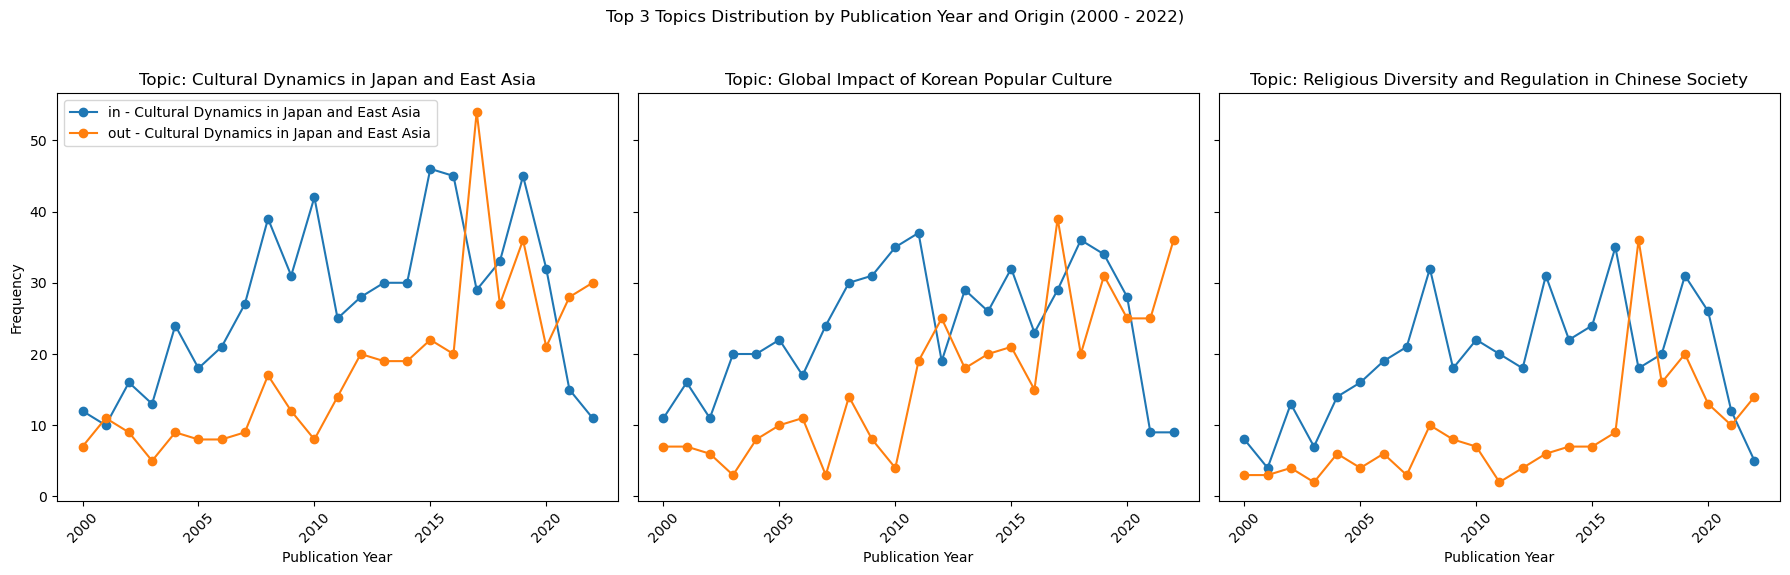

In [81]:
# topics_name 리스트를 행으로 확장합니다.
df_exploded = df.explode('topics_name')

# 빈 topics_name 제거합니다.
df_exploded = df_exploded[df_exploded['topics_name'].notna()]

# 2000년부터 2022년까지의 데이터 필터링
df_filtered = df_exploded[(df_exploded['publication_year'] >= 2000) & (df_exploded['publication_year'] <= 2022)]

# topics_name별 전체 빈도수를 계산하고 상위 3개만 추출합니다.
top_3_topics = df_filtered['topics_name'].value_counts().nlargest(3).index

# 상위 3개 topics_name에 대한 시각화를 준비합니다.
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, topic in enumerate(top_3_topics):
    # 특정 topic에 대한 데이터 필터링
    topic_data = df_filtered[df_filtered['topics_name'] == topic]
    
    # origin 별로 분리하여 연도별 빈도수 계산
    for origin in ['in', 'out']:
        yearly_distribution = topic_data[topic_data['origin'] == origin].groupby('publication_year').size()
        axs[i].plot(yearly_distribution.index, yearly_distribution, marker='o', linestyle='-', label=f'{origin} - {topic}')
    
    axs[i].set_title(f'Topic: {topic}')
    axs[i].set_xlabel('Publication Year')
    axs[i].tick_params(axis='x', rotation=45)
    
    if i == 0:
        axs[i].set_ylabel('Frequency')
        axs[i].legend()

plt.suptitle('Top 3 Topics Distribution by Publication Year and Origin (2000 - 2022)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

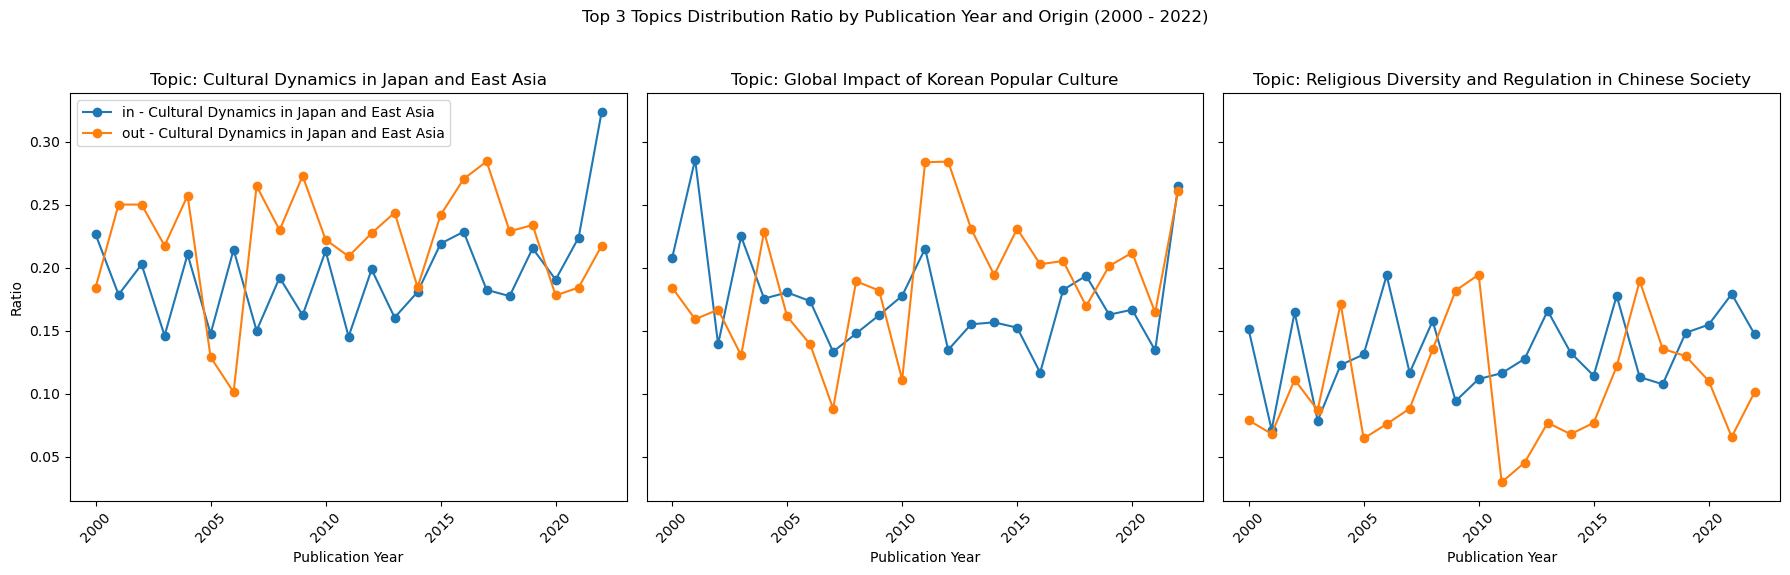

In [89]:
# 각 연도 및 origin에 대한 총 출현 횟수 계산
total_count_per_year_origin = df_filtered.groupby(['publication_year', 'origin']).size().reset_index(name='total_count')

# 각 topic, 연도, origin에 대한 빈도수 계산
frequency_per_topic_year_origin = df_filtered.groupby(['topics_name', 'publication_year', 'origin']).size().reset_index(name='frequency')

# 빈도수 데이터프레임과 총 출현 횟수 데이터프레임을 병합하여 비율 계산
merged_df = pd.merge(frequency_per_topic_year_origin, total_count_per_year_origin, on=['publication_year', 'origin'])

# 비율 계산
merged_df['ratio'] = merged_df['frequency'] / merged_df['total_count']

# 상위 3개 topics_name에 대한 시각화 준비
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, topic in enumerate(top_3_topics):
    ax = axs[i]
    # 특정 topic에 대한 데이터 필터링
    topic_data = merged_df[merged_df['topics_name'] == topic]
    
    # origin 별로 분리하여 연도별 비율 시각화
    for origin in ['in', 'out']:
        yearly_ratio = topic_data[topic_data['origin'] == origin]
        ax.plot(yearly_ratio['publication_year'], yearly_ratio['ratio'], marker='o', linestyle='-', label=f'{origin} - {topic}')
    
    ax.set_title(f'Topic: {topic}')
    ax.set_xlabel('Publication Year')
    ax.tick_params(axis='x', rotation=45)
    
    if i == 0:
        ax.set_ylabel('Ratio')
        ax.legend()

plt.suptitle('Top 3 Topics Distribution Ratio by Publication Year and Origin (2000 - 2022)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [91]:
df.loc[df['topics_name'].str.len()>0,'topics_name'].map(lambda x:x[0]).value_counts()

topics_name
Global Impact of Korean Popular Culture                      658
Cultural Dynamics in Japan and East Asia                     559
Socio-Political Dynamics of North Korea                      442
Religious Diversity and Regulation in Chinese Society        405
Evolution of East Asian Developmental States                  73
                                                            ... 
Rhetoric and Democracy in Public Discourse                     1
Intergenerational Mobility and Social Stratification           1
Depoliticisation in British Politics and Society               1
Leisure Activities and Subjective Well-Being Relationship      1
Societal Reactions to Moral Panics                             1
Name: count, Length: 283, dtype: int64

In [92]:
df['subfield_name'].explode().value_counts()

subfield_name
Cultural Studies                                 2497
Sociology and Political Science                  2086
Political Science and International Relations     276
Language and Linguistics                          107
Philosophy                                        104
                                                 ... 
Signal Processing                                   1
Media Technology                                    1
Cancer Research                                     1
Molecular Biology                                   1
Psychiatry and Mental health                        1
Name: count, Length: 96, dtype: int64

In [93]:
df.loc[df['subfield_name'].str.len()>0,'subfield_name'].map(lambda x:x[0]).value_counts()

subfield_name
Cultural Studies                                 1236
Sociology and Political Science                  1095
Political Science and International Relations     134
Language and Linguistics                           63
Philosophy                                         45
                                                 ... 
Management of Technology and Innovation             1
Atmospheric Science                                 1
Issues, ethics and legal aspects                    1
Anatomy                                             1
Developmental and Educational Psychology            1
Name: count, Length: 78, dtype: int64

In [94]:
df['field_name'].explode().value_counts()

field_name
Social Sciences                                 5290
Arts and Humanities                              507
Computer Science                                 153
Economics, Econometrics and Finance              112
Environmental Science                             83
Psychology                                        68
Agricultural and Biological Sciences              45
Business, Management and Accounting               41
Medicine                                          28
Health Professions                                17
Nursing                                           13
Earth and Planetary Sciences                      12
Engineering                                       10
Biochemistry, Genetics and Molecular Biology       8
Physics and Astronomy                              6
Decision Sciences                                  3
Neuroscience                                       2
Materials Science                                  1
Name: count, dtype: int64

In [95]:
df.loc[df['field_name'].str.len()>0,'field_name'].map(lambda x:x[0]).value_counts()

field_name
Social Sciences                                 2640
Arts and Humanities                              225
Computer Science                                  66
Environmental Science                             40
Psychology                                        37
Economics, Econometrics and Finance               34
Agricultural and Biological Sciences              21
Medicine                                          15
Business, Management and Accounting               11
Engineering                                        6
Health Professions                                 6
Earth and Planetary Sciences                       5
Nursing                                            4
Physics and Astronomy                              3
Decision Sciences                                  2
Biochemistry, Genetics and Molecular Biology       2
Materials Science                                  1
Name: count, dtype: int64

##### df_cited

In [98]:
df_cited

id  \
0     https://openalex.org/W3014747407   
1     https://openalex.org/W1935281467   
2      https://openalex.org/W253152192   
3      https://openalex.org/W815816339   
4     https://openalex.org/W2071789989   
...                                ...   
3994  https://openalex.org/W2096790709   
3995  https://openalex.org/W2048433567   
3996  https://openalex.org/W1983562034   
3997  https://openalex.org/W2026740962   
3998  https://openalex.org/W3137638170   

                                              doi  \
0      https://doi.org/10.33526/ejks.20201902.171   
1           https://doi.org/10.1353/seo.2015.0012   
2                                            None   
3                                            None   
4           https://doi.org/10.1353/jks.2013.0002   
...                                           ...   
3994  https://doi.org/10.1007/978-3-322-90724-0_6   
3995          https://doi.org/10.3987/com-99-8699   
3996         https://doi.org/10.1353/ks.1998.0003   
3997    https://doi.org/10.1142/s0192415x98000270   
3998                                         None   

                                                  title  \
0     Modern Womanhood, the Ideology of the Housewif...   
1     Progeny of the Koryŏ Dynasty: The Kaesŏng Wang...   
2     Mortuary Ritual and Social Development in Iron...   
3           A study of the Boseong River Valley culture   
4     Racialization and Colonial Space: Intermarriag...   
...                                                 ...   
3994  Konflikte um eine Strategische Umweltverträgli...   
3995   Synthesis of Optically Active 2-Piperidylglycine   
3996  Playful Reconstruction of Gender in P'ansori S...   
3997  Effects of <i>ChunDoSunBup</i> Qi-training on ...   
3998  Wit(h)nessing trauma in Han Kang’s the white b...   

                                           display_name  publication_year  \
0     Modern Womanhood, the Ideology of the Housewif...              2020   
1     Progeny of the Koryŏ Dynasty: The Kaesŏng Wang...              2015   
2     Mortuary Ritual and Social Development in Iron...              2014   
3           A study of the Boseong River Valley culture              2002   
4     Racialization and Colonial Space: Intermarriag...              2013   
...                                                 ...               ...   
3994  Konflikte um eine Strategische Umweltverträgli...              1998   
3995   Synthesis of Optically Active 2-Piperidylglycine              1999   
3996  Playful Reconstruction of Gender in P'ansori S...              1998   
3997  Effects of <i>ChunDoSunBup</i> Qi-training on ...              1998   
3998  Wit(h)nessing trauma in Han Kang’s the white b...              2020   

     publication_date                                                ids  \
0          2020-04-01  {'openalex': 'https://openalex.org/W3014747407...   
1          2015-01-01  {'openalex': 'https://openalex.org/W1935281467...   
2          2014-01-01  {'openalex': 'https://openalex.org/W253152192'...   
3          2002-12-01  {'openalex': 'https://openalex.org/W815816339'...   
4          2013-03-13  {'openalex': 'https://openalex.org/W2071789989...   
...               ...                                                ...   
3994       1998-01-01  {'openalex': 'https://openalex.org/W2096790709...   
3995       1999-01-01  {'openalex': 'https://openalex.org/W2048433567...   
3996       1998-01-01  {'openalex': 'https://openalex.org/W1983562034...   
3997       1998-01-01  {'openalex': 'https://openalex.org/W2026740962...   
3998       2020-01-01  {'openalex': 'https://openalex.org/W3137638170...   

     language                                   primary_location  \
0          en  {'is_oa': False, 'landing_page_url': 'https://...   
1          en  {'is_oa': False, 'landing_page_url': 'https://...   
2          en  {'is_oa': False, 'landing_page_url': 'https://...   
3          en  {'is_oa': False, 'landing_page_url': 'https://...   
4      